# Problem description

Plot energy profiles of reco and sim tracksters.

The task gets much more difficult with the increasing overlap.

Two approaches for matching are possible:
- simtrackster that has the largest fraction of the reco trackster energy
- simtrackster in which the reco trackster makes up the largest fraction

In [181]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc

# plotting config
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.plotting import plot_event, plot_tracksters
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map, get_bary, get_lc
from reco.matching import get_highest_energy_fraction_simtracksters, match_best_simtrackster

# %matplotlib widget
%matplotlib inline

data_root = "data"

# TODO: photon

# ds_name = "MultiParticle"
# file_name = f"{raw_dir}/new_ntuples_15163313_8.root"

ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [187]:
eid = 0
E_TH = 2

# get layercluster layers and energy
e_lc = tracksters["vertices_energy"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]

# get layercluster layers and energy
sim_e_lc = simtracksters["stsSC_vertices_energy"].array()[eid]
sim_z_lc = simtracksters["stsSC_vertices_z"].array()[eid]
sim_m_lc = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

raw_e = tracksters["raw_energy"].array()[eid]
print("Events:", len(tracksters["raw_energy"].array()))

Events: 100


In [188]:
z_set = set(np.round(x) for x in ak.flatten(sim_z_lc, axis=None))
z_list = list(x for x in sorted(z_set))
z_map = {z: i for i, z in enumerate(z_list)}
print(z_map)

{322.0: 0, 323.0: 1, 325.0: 2, 326.0: 3, 328.0: 4, 329.0: 5, 331.0: 6, 332.0: 7, 334.0: 8, 335.0: 9, 337.0: 10, 338.0: 11, 340.0: 12, 341.0: 13, 344.0: 14, 345.0: 15, 347.0: 16, 348.0: 17, 350.0: 18, 351.0: 19, 353.0: 20, 354.0: 21, 357.0: 22, 358.0: 23, 360.0: 24, 361.0: 25, 368.0: 26, 374.0: 27, 381.0: 28, 387.0: 29, 393.0: 30, 400.0: 31, 406.0: 32, 412.0: 33, 418.0: 34, 425.0: 35, 431.0: 36, 439.0: 37, 447.0: 38, 456.0: 39, 464.0: 40, 472.0: 41, 480.0: 42, 488.0: 43, 497.0: 44, 505.0: 45, 513.0: 46}


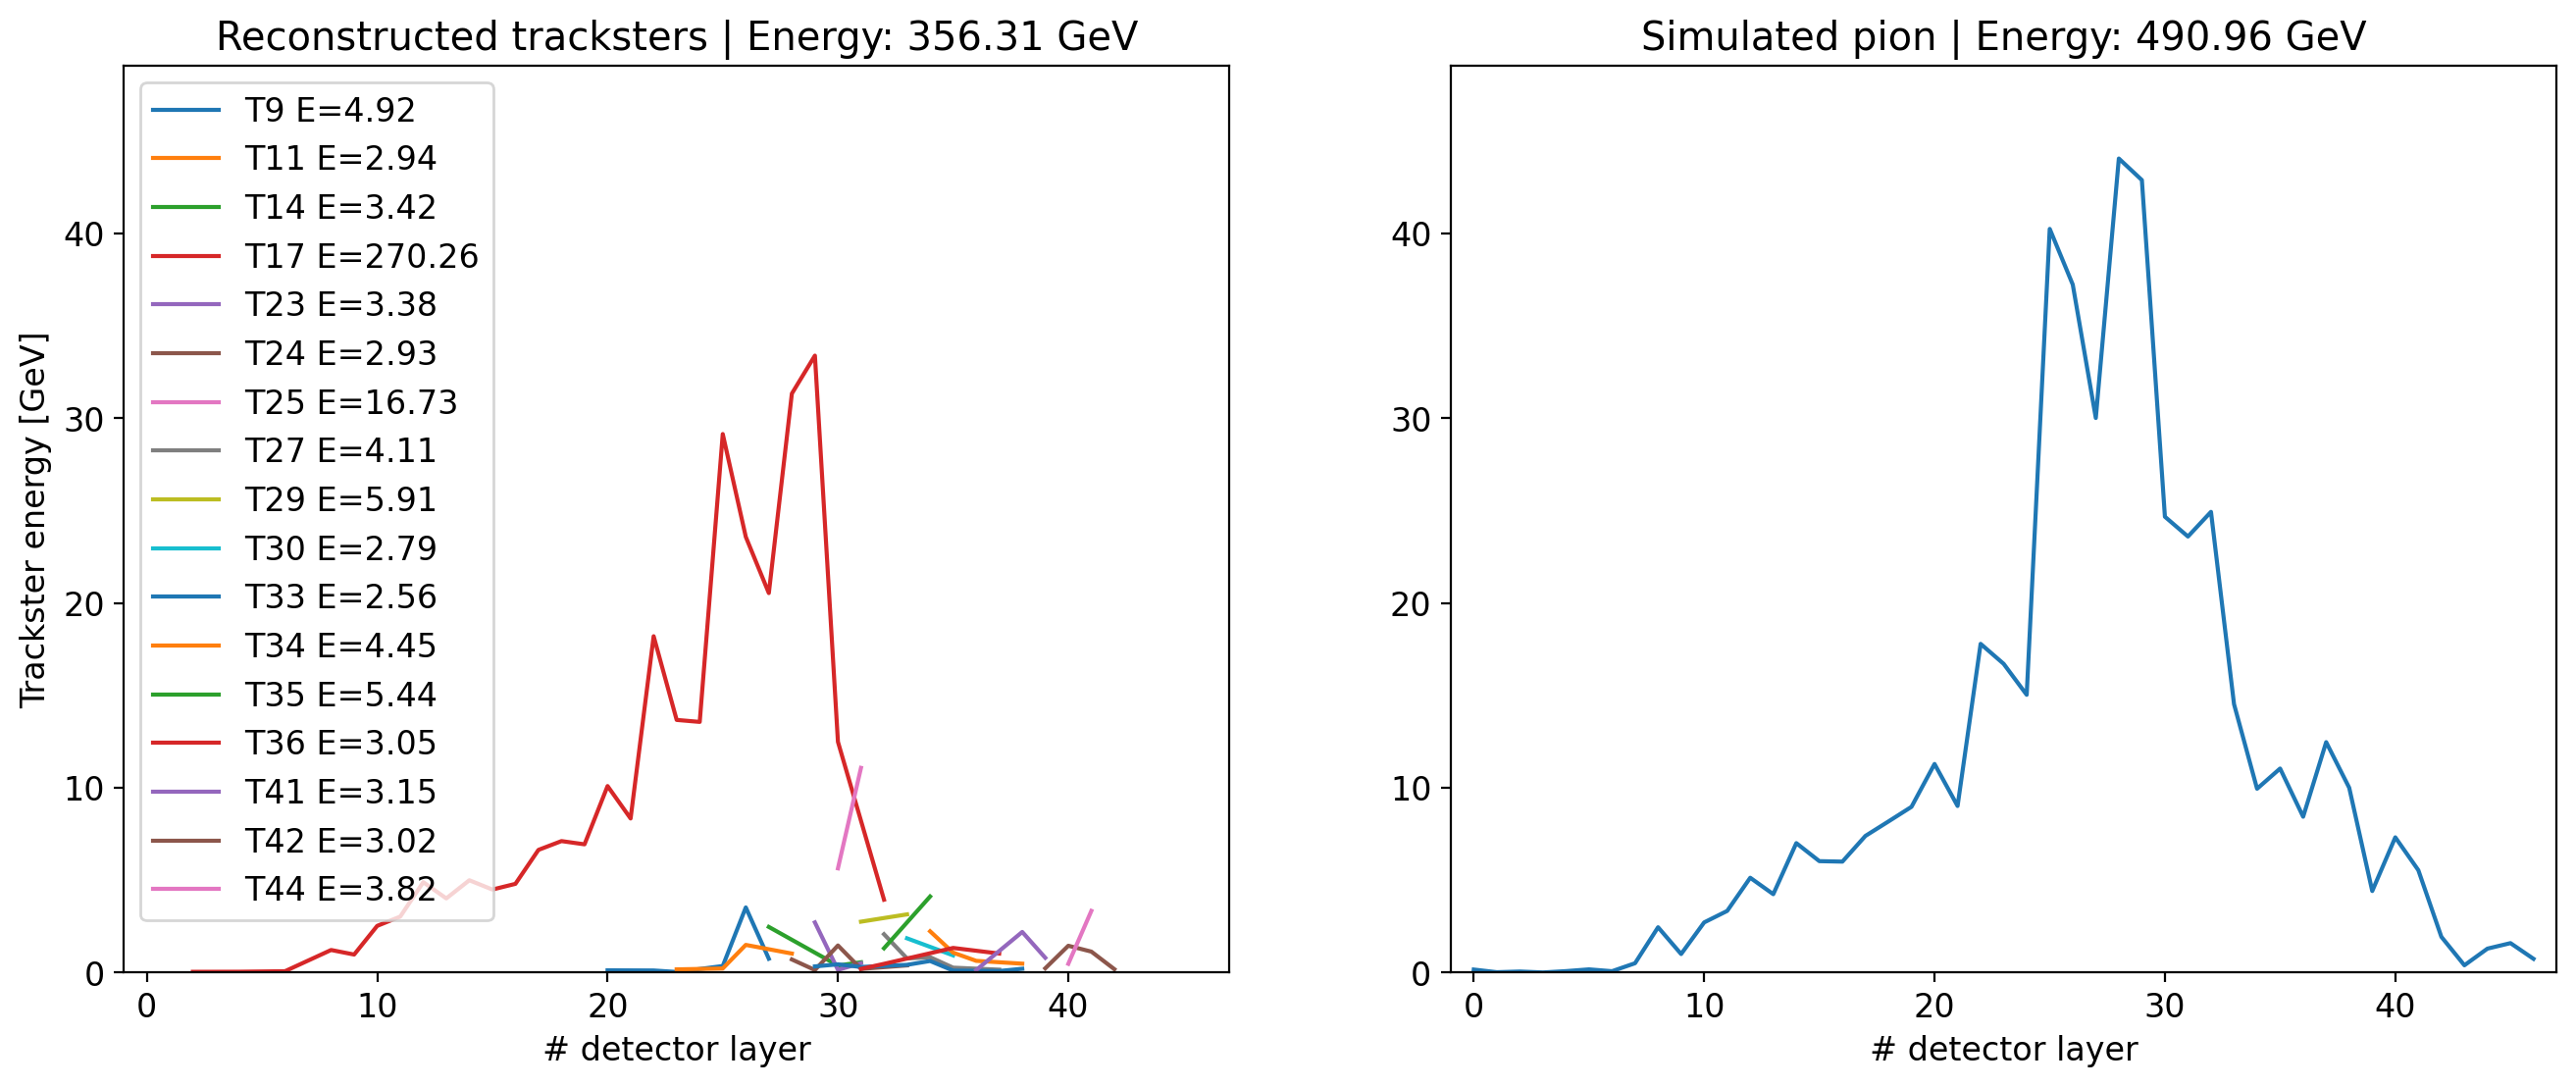

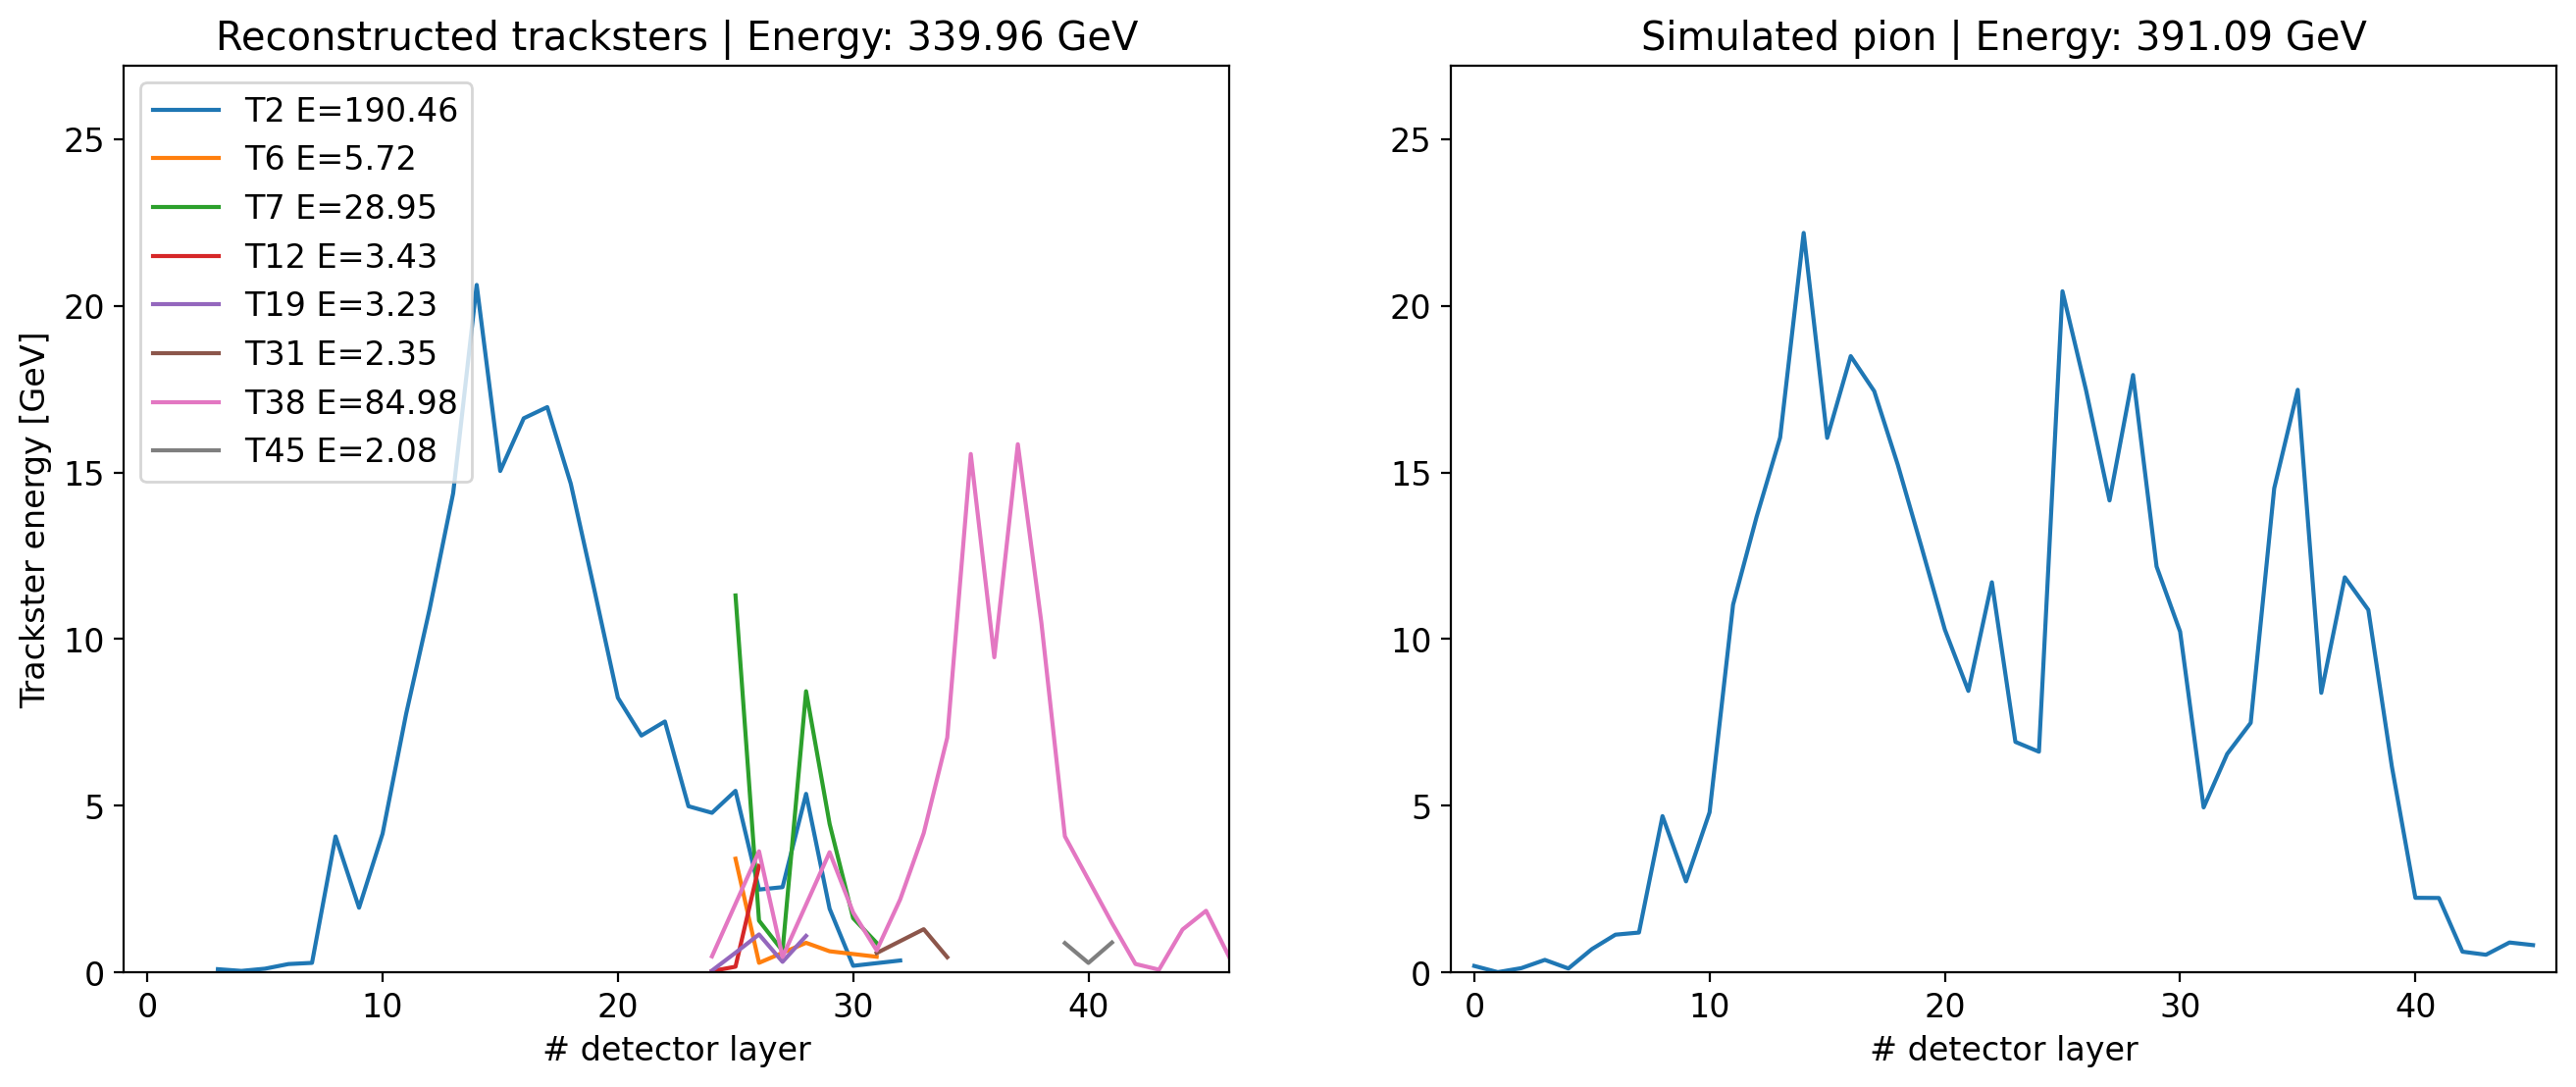

In [190]:
axs = []
ntx = min((20, len(sim_e_lc)))


simtrackster_energy = [0] * ntx
reconstructed_energy = [0] * ntx
matched_trackster_counts = [0] * ntx

figs = []

for i in range(ntx):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    figs.append(fig)

    stm = sim_m_lc[i]

    # normalize the simtrackster energy by multiplicity
    ste = sim_e_lc[i] / stm

    stz = list([z_map[np.round(x)] for x in sim_z_lc[i]])

    st_agg = {}
    for e, z in zip(ste, stz):
        if z in st_agg:
            st_agg[z] += e
        else:
            st_agg[z] = e
    
    st_arr = np.array(sorted(st_agg.items()))

    xmin = st_arr[0, 0] - 1
    xmax = st_arr[-1, 0] + 1
    ymax = max(st_arr[:, 1]) + 5
    
    ax1.set_ylabel("Trackster energy [GeV]")
    ax1.set_xlabel("# detector layer")
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(0, ymax)

    ax2.set_title(f"Simulated pion | Energy: {sum(ste):.2f} GeV")
    ax2.plot(st_arr[:,0], st_arr[:,1])
    ax2.set_xlabel("# detector layer")
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(0, ymax)

    simtrackster_energy[i] += sum(ste)
    axs.append(ax1)

# _, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)
_, reco_st = match_best_simtrackster(tracksters, associations, eid)

for t_id in range(len(raw_e)):
    te = e_lc[t_id]
    tz = [z_map[np.round(x)] for x in z_lc[t_id]]

    # aggregate per layer
    t_agg = {}
    for e, z in zip(te, tz):
        if z in t_agg:
            t_agg[z] += e
        else:
            t_agg[z] = e

    stid = reco_st[t_id]

    if stid >= ntx:
        continue

    ax = axs[stid]

    t_arr = np.array(sorted(t_agg.items()))
    reconstructed_energy[stid] += sum(te)
    matched_trackster_counts[stid] += 1
    
    if sum(te) > E_TH:
        ax.plot(t_arr[:,0], t_arr[:,1], label=f"T{t_id} E={sum(te):.2f}")
        ax.legend()

    ax.set_title(f"Reconstructed tracksters | Energy: {reconstructed_energy[stid]:.2f} GeV")

# figs[0].savefig('export/photon-profile-LE.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [191]:
matched_trackster_counts

[26, 20]

## Reconstructed energy

In [192]:
total_sim = np.array(simtrackster_energy)
total_reco = np.array(reconstructed_energy)
total_frac = 100*sum(total_reco)/sum(total_sim)

fractions = total_reco / total_sim

print(f"Total simtracksters energy: {sum(total_sim):.3f} GeV")
print(f"Total reconstructed energy: {sum(total_reco):.3f} Gev ({total_frac:.2f}%)")
print(f"Mean reconstruction: {100*np.mean(fractions):.2f}%")

Total simtracksters energy: 882.044 GeV
Total reconstructed energy: 696.270 Gev (78.94%)
Mean reconstruction: 79.75%


## Energy threshold

The goal is to connect low-energy tracksters to high-energy tracksters.

As visible on the plots below:
- reco has the most tracksters in the sub-10Gev range
- sim has none / much fewer

Note that this is in a zoomed in area (0, 100).
The goal is to reconnect all the tracksters in the sub 10 GeV Range to their larger counterparts.

634.3994750976562


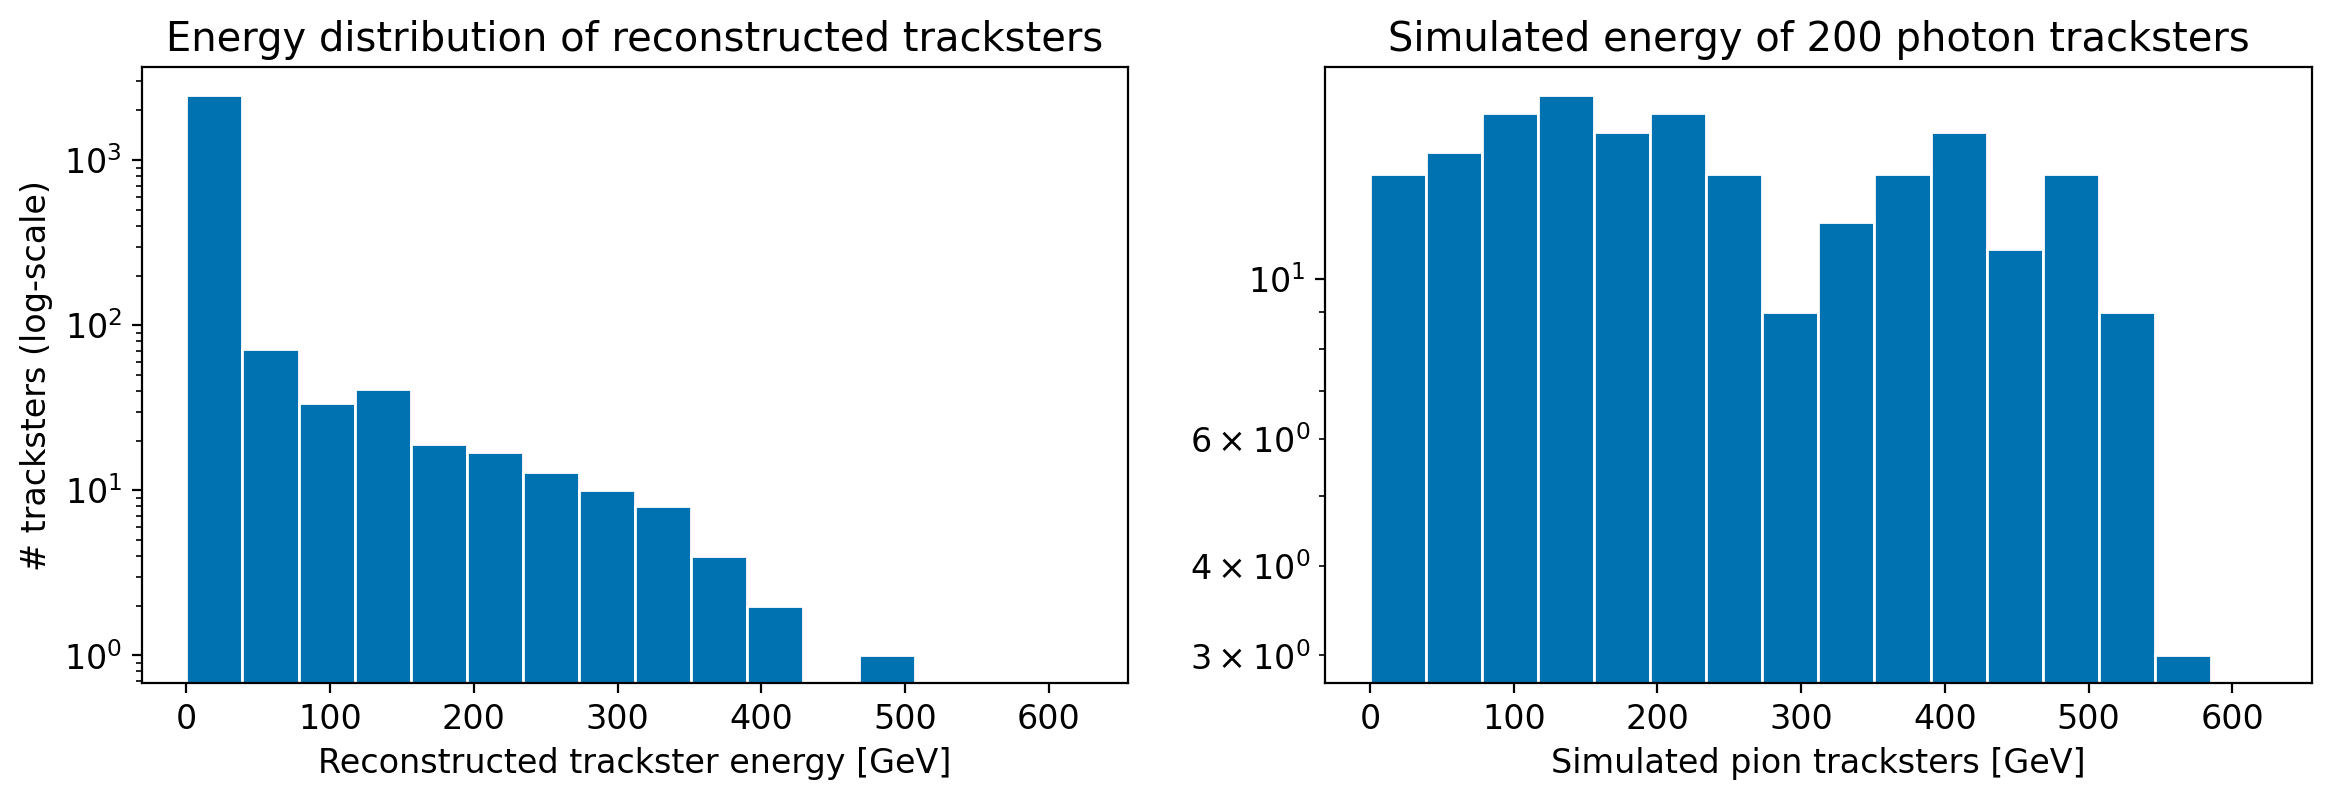

In [193]:
tenergy = ak.flatten(tracksters["raw_energy"].array())
stenergy = ak.flatten(simtracksters["stsSC_raw_energy"].array())

print(max(stenergy))

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(121)
ax.hist(tenergy, bins=16, edgecolor="white", color="#0072B2", range=(0, 624))

ax.set_yscale("log")
ax.set_ylabel("# tracksters (log-scale)")
ax.set_xlabel("Reconstructed trackster energy [GeV]")
ax.set_title("Energy distribution of reconstructed tracksters")


ax = fig.add_subplot(122)
ax.set_yscale("log")
ax.set_title("Simulated energy of 200 photon tracksters")
ax.set_xlabel("Simulated pion tracksters [GeV]")
ax.hist(stenergy, bins=16, edgecolor="white", color="#0072B2", range=(0, 624))
plt.show()

# fig.savefig('export/pion-energy-distribution-100e.png', dpi=300, bbox_inches='tight', transparent=True)